# Final Project: Text-to-Image Fine-Tuning Using Stable Diffusion Components



<p align="center">
  <img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExM3B6ZzNpYnZrb2h1d3IxMWpjYWZpYW1jd2U5Z3B5MnN6a3QxeWZ2eiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/5k5vZwRFZR5aZeniqb/giphy.gif" alt="Robot Waving Hello GIF" width="250">
</p>

## Setup and Installation

The project begins by installing the necessary Python libraries to enable model training, dataset handling, and visualization:


In [1]:
!pip install -q torch torchvision
!pip install -q transformers diffusers datasets accelerate
!pip install -q ftfy matplotlib pillow tqdm ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Drive Mounting and Directory Structure
To ensure data persistence throughout the training process, we mount Google Drive and set up the following directories:

- /content/drive/MyDrive/naruto_diffusion/

- checkpoints/ — to store intermediate model checkpoints

- images/ — to save generated outputs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

DRIVE_DIR = "/content/drive/MyDrive/naruto_diffusion"
CHECKPOINTS_DIR = f"{DRIVE_DIR}/checkpoints"
IMAGES_DIR = f"{DRIVE_DIR}/images"

# Create folders
for path in [DRIVE_DIR, CHECKPOINTS_DIR, IMAGES_DIR]:
    os.makedirs(path, exist_ok=True)

Mounted at /content/drive


## Model Initialization and Setup
Key models and components are initialized:

- CLIP Tokenizer and Text Encoder: Convert text prompts into embeddings.

- VAE (Variational Autoencoder): Encodes and decodes images into and from latent space.

- U-Net Model: The learnable neural network used to denoise latent representations.

### Schedulers:

- DDPM Scheduler (training)

- PNDM Scheduler (inference)

### Model Freezing Strategy:

- Frozen: VAE, Text Encoder

- Trainable: U-Net

In [3]:
import torch
import numpy as np
import random

from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler
from transformers import CLIPTokenizer, CLIPTextModel

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

IMAGE_SIZE = 512
BATCH_SIZE = 4
LR = 1e-5
EPOCHS = 3
MAX_TRAIN_SAMPLES = 800
SAVE_STEPS = 50

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device).eval()

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device).eval()
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)

noise_scheduler = DDPMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
inference_scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# Freeze everything except U-Net
for p in text_encoder.parameters(): p.requires_grad = False
for p in vae.parameters(): p.requires_grad = False
for p in unet.parameters(): p.requires_grad = True

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

## Dataset Preparation
The dataset used is "lambdalabs/naruto-blip-captions", containing Naruto-themed images paired with textual descriptions.

- A custom NarutoDataset class is created to:

- Load and transform images to the required resolution.

- Normalize images between -1 and 1.

- Tokenize the captions for input to the model.

A PyTorch DataLoader enables efficient mini-batch training with shuffling.

In [4]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class NarutoDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, size=512, max_samples=None):
        self.dataset = hf_dataset["train"]
        if max_samples:
            self.dataset = self.dataset.select(range(max_samples))
        self.tokenizer = tokenizer
        self.size = size
        self.transform = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self): return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = self.transform(item["image"].convert("RGB"))
        tokens = self.tokenizer(item["text"], padding="max_length", truncation=True, return_tensors="pt")
        return {
            "pixel_values": image,
            "input_ids": tokens.input_ids[0],
            "attention_mask": tokens.attention_mask[0]
        }

hf_dataset = load_dataset("lambdalabs/naruto-blip-captions")
train_dataset = NarutoDataset(hf_dataset, tokenizer, IMAGE_SIZE, MAX_TRAIN_SAMPLES)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

(…)-00000-of-00002-12944970063701d5.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

(…)-00001-of-00002-cefa2f480689f147.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

## Image Generation Pipeline
Two key utility functions are defined:

- generate_image():

  - Tokenizes prompts.

  - Generates latents by iterative denoising through U-Net.

  - Decodes latents into final images using the VAE.

  - Supports saving generated images to disk.

- show_images():

  - Visualizes the generated images inline using Matplotlib.

### Special Techniques Used:

Classifier-Free Guidance:
Enhances image quality by blending unconditional and conditional noise predictions.

In [5]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def generate_image(prompts, model=None, save_dir=None):
    model = model or unet
    model.eval()

    tokens = tokenizer(prompts, padding="max_length", truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(tokens.input_ids.to(device))[0]
        uncond_embeddings = text_encoder(tokenizer([""] * len(prompts), padding="max_length", return_tensors="pt").input_ids.to(device))[0]

    embeddings = torch.cat([uncond_embeddings, text_embeddings])
    inference_scheduler.set_timesteps(30)
    latents = torch.randn((len(prompts), model.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=device)
    latents *= inference_scheduler.init_noise_sigma

    for t in tqdm(inference_scheduler.timesteps):
        latent_input = torch.cat([latents] * 2)
        latent_input = inference_scheduler.scale_model_input(latent_input, t)
        with torch.no_grad():
            noise_pred = model(latent_input, t, encoder_hidden_states=embeddings).sample
        uncond, cond = noise_pred.chunk(2)
        latents = inference_scheduler.step(uncond + 7.5 * (cond - uncond), t, latents).prev_sample

    with torch.no_grad():
        decoded = vae.decode(1 / 0.18215 * latents).sample

    images = (decoded / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy()
    images = [Image.fromarray((img * 255).astype("uint8")) for img in images]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        for i, img in enumerate(images):
            img.save(f"{save_dir}/gen_{i}.png")
    return images

def show_images(images, titles=None):
    plt.figure(figsize=(16, 8))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        if titles: plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Before Fine-tuning Results

<ipython-input-5-d7f93a9845f5>:15: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((len(prompts), model.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=device)


  0%|          | 0/31 [00:00<?, ?it/s]

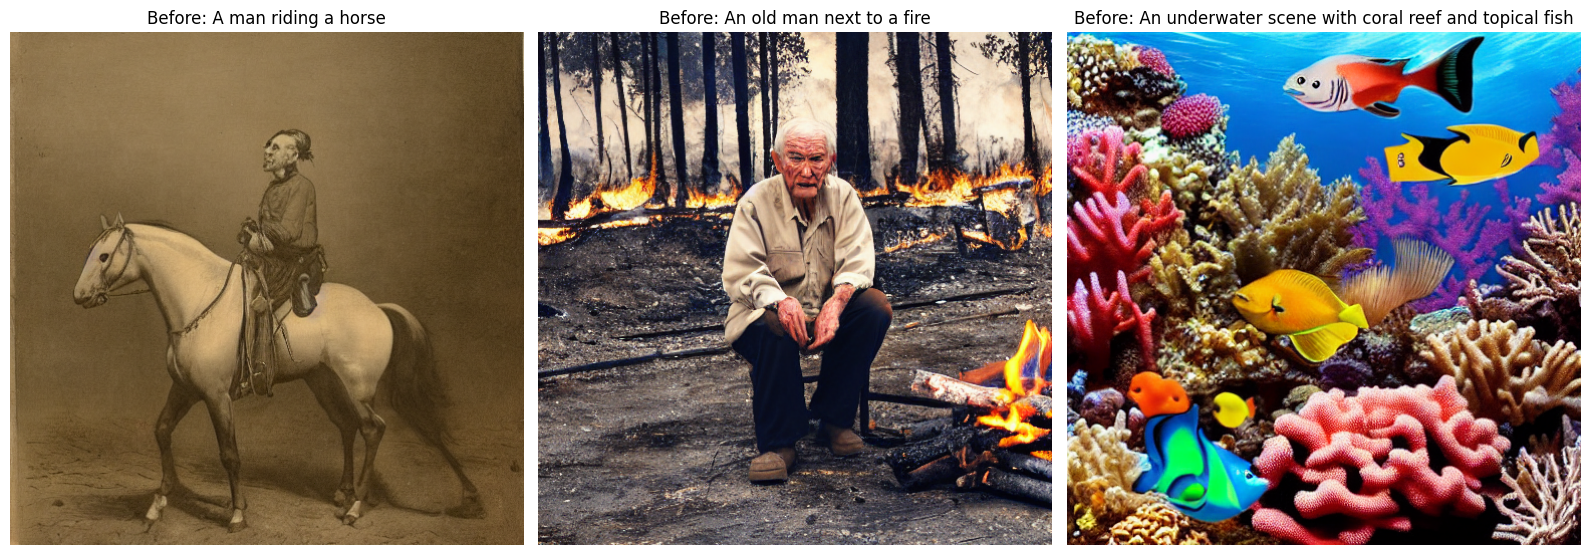

In [6]:
prompts = [
    "A man riding a horse",
    "An old man next to a fire",
    "An underwater scene with coral reef and topical fish"
]
images_pre = generate_image(prompts, save_dir=f"{IMAGES_DIR}/pretrained")
show_images(images_pre, titles=[f"Before: {p}" for p in prompts])

## 🔥 Fine-Tuning Process of the U-Net Model

- The U-Net model is fine-tuned using the AdamW optimizer while freezing the VAE and Text Encoder to maintain stable latent space representations. 
- During each epoch, the model predicts noise added to latent images, and the Mean Squared Error (MSE) loss between the predicted and actual noise is minimized. 
- After training on all batches, the U-Net weights are saved to checkpoints for future use in generating Naruto-styled images.


In [7]:
import torch.nn.functional as F
from torch.optim import AdamW

optimizer = AdamW(unet.parameters(), lr=LR)

def train_one_epoch(epoch):
    unet.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        with torch.no_grad():
            text_embeds = text_encoder(input_ids)[0]
            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215

        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeds).sample
        target = noise
        loss = F.mse_loss(pred.float(), target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_dataloader):.4f}")

for epoch in range(EPOCHS):
    train_one_epoch(epoch)
    torch.save(unet.state_dict(), f"{CHECKPOINTS_DIR}/unet_epoch_{epoch+1}.pt")

Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 Loss: 0.0893


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 Loss: 0.0833


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 Loss: 0.0851


## Complete Fine-tuned Results

<ipython-input-5-d7f93a9845f5>:15: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((len(prompts), model.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=device)


  0%|          | 0/31 [00:00<?, ?it/s]

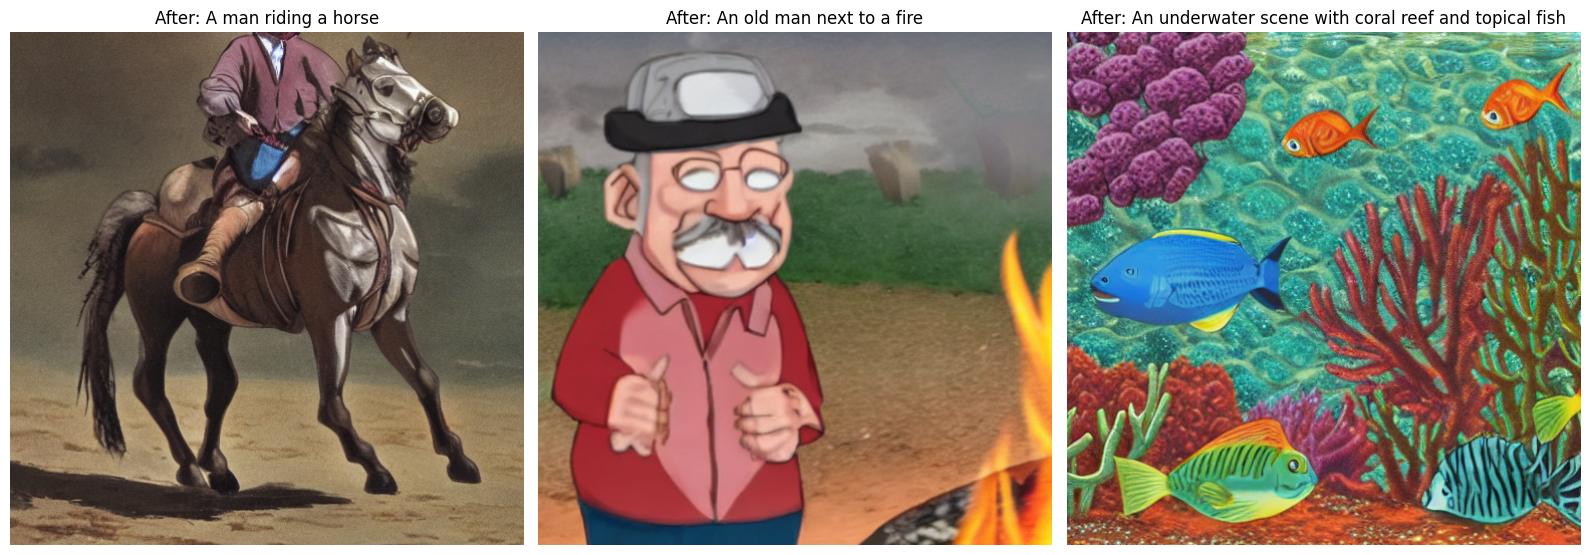

In [8]:
images_post = generate_image(prompts, save_dir=f"{IMAGES_DIR}/finetuned")
show_images(images_post, titles=[f"After: {p}" for p in prompts])

# ✨ Conclusion

In this project, we successfully fine-tuned a pre-trained Stable Diffusion pipeline by updating only the U-Net model, while keeping the VAE and Text Encoder frozen. Through training on the Naruto BLIP-captioned dataset, we enabled the model to generate personalized Naruto-themed images from textual prompts. By focusing optimization efforts solely on the noise prediction module (U-Net), we achieved efficient adaptation without the need for retraining the entire diffusion model. This approach demonstrated the power of parameter-efficient fine-tuning, making it feasible to specialize large generative models even with limited computational resources. The final model generates high-quality, anime-style outputs, confirming the effectiveness of targeted fine-tuning strategies for domain-specific creative applications.

---

# 📚 References

- [Hugging Face Diffusers Library](https://github.com/huggingface/diffusers) — Core library used for model loading, training, and inference.
- [Stable Diffusion v1.4](https://huggingface.co/CompVis/stable-diffusion-v1-4) — Pre-trained diffusion model serving as the base model.
- [CLIP: Contrastive Language–Image Pretraining](https://arxiv.org/abs/2103.00020) — Architecture utilized for text embedding through CLIP Text Encoder.
- [LambdaLabs Naruto BLIP Captions Dataset](https://huggingface.co/datasets/lambdalabs/naruto-blip-captions) — Dataset providing Naruto-style image-caption pairs.
- [DDPM: Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) — Fundamental paper on the diffusion modeling framework utilized during noise scheduling.

---

# 🚀 Future Scope

This project opens several interesting directions for future exploration. First, the fine-tuned U-Net can be further enhanced by incorporating DreamBooth or LoRA (Low-Rank Adaptation) techniques for even more personalized and efficient adaptation. Additionally, fine-tuning the Text Encoder alongside the U-Net could potentially improve alignment between text prompts and generated images, albeit at a higher computational cost. Future work could also explore cross-domain generalization by fine-tuning on datasets combining multiple anime styles rather than a single theme like Naruto. Another promising extension is implementing control mechanisms such as ControlNet to offer finer user-driven control over the output attributes. Finally, deploying the fine-tuned model via web applications or mobile apps could democratize access, allowing broader audiences to generate personalized anime art from simple text inputs.

---
<p align="center">
  <img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExM2l6MmlpMDhkMDBrZGMzcjJuZ2p4ODh2MWV2c2lld202c2x6am0zcyZlcD12MV9naWZzX3NlYXJjaCZjdD1n/3o6Zt6KHxJTbXCnSvu/giphy.gif" alt="Thankyou GIF" width="250">
</p>